In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import networkx as nx

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

from copy import deepcopy as copy

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Update Process

In [2]:
def Laplacian(G):
    k_in = np.sum(G, 0)
    k_out = np.sum(G, 1)
    return np.diag(k_in + k_out) - (A + A.T)

def operator_P(x, P):
    if len(x.shape) == 2:
        x_P = x[P][:, P]
    elif len(x.shape) == 1:
        x_P = x[P]
    else:
        raise ValueError("invalid shape")
    return x_P

def get_neighbors(G, P):
    idx_0 = set(np.nonzero(G[P])[1])
    idx_1 = set(np.nonzero(G[:,P])[0])
    N = idx_0.union(idx_1) - set(P)
    return list(N)

In [26]:
def update_ranks(A, s_0, P, num_iter=100, tol=1e-7):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)

    L_p = operator_P(L, P)
    RHS_p = operator_P(RHS, P)
    delta_p = LA.solve(L_p, RHS_p)
    s_est[P] = s_est[P] + delta_p
    
    N = get_neighbors(A, P)
    for i in range(num_iter):
        L_n = operator_P(L, N)
        RHS_n = operator_P(d_hat - np.matmul(L, s_est), N)
        delta_n = LA.solve(L_n, RHS_n)
        s_est[N] = s_est[N] + delta_n
        N = get_neighbors(A, N)
    
    return s_est

def kth_order_update(A, s_0, N0, order):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)
    
    N = set()
    for k in range(order):
        N = N.union(get_neighbors(A, list(N)))
    N = list(N)
    
    L_n = operator_P(L, N)
    RHS_n = operator_P(RHS, N)
    delta_n = LA.solve(L_n, RHS_n)
    s_est[N] = s_est[N] + delta_n
    
    return s_est, N

## Test on a small network

In [4]:
N = 5

A_0 = np.zeros((N, N))
A_0[0, :] = np.array([0, 3, 0, 0, 0])
A_0[1, :] = np.array([10, 0, 6, 0, 0])
A_0[2, :] = np.array([0, 6, 0, 7, 0])
A_0[3, :] = np.array([0, 0, 0, 0, 1])
A_0[4, :] = np.array([0, 0, 0, 3, 0])

print("Network:")
print(A_0)

s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=0.8)

print("Ranks:")
print(s_0)

Network:
[[ 0.  3.  0.  0.  0.]
 [10.  0.  6.  0.  0.]
 [ 0.  6.  0.  7.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  3.  0.]]
Ranks:
[0.84561991 1.83217641 1.83217634 0.         0.91608823]


Add some edges between two nodes

In [5]:
# fix nodes
node_x = 0
node_y = 2

# fix number of edges
A_xy = 1
A_yx = 0

# update network
A = copy(A_0)
A[node_x, node_y] += A_xy
A[node_y, node_x] += A_yx

print("Updated network:")
print(A)

# calculate new ranks
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=0.8)

print("Updated ranks:")
print(s)

Updated network:
[[ 0.  3.  1.  0.  0.]
 [10.  0.  6.  0.  0.]
 [ 0.  6.  0.  7.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  3.  0.]]
Updated ranks:
[1.28195283 2.11207007 1.90191389 0.         0.95095709]


In [6]:
P = [node_x, node_y]
s_est = update_ranks(A, s_0, P)
s_est = tl.adjust_ranks(s_est, A, p_ij=0.8, interval=(-10, 20))

print("Estimated ranks:")
print(s_est)

print("L2 error:")
print(LA.norm(s - s_est, ord=2))

Estimated ranks:
[1.28195315 2.11207035 1.9019141  0.         0.95095705]
L2 error:
4.739344317975831e-07


## Test on larger network

In [9]:
beta = 0.5
p_ij = 1 / (1 + np.exp(-2*beta))
alpha = 1
N = 1000
K = 10

A_0 = sr.SpringRank_planted_network(N, beta, alpha, K)
s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=p_ij)

In [10]:
node_x = 135
node_y = 970
A_xy = 24
A_yx = 1

A = copy(A_0)
A[node_x, node_y] = A_xy
A[node_y, node_x] = A_yx

In [11]:
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=p_ij)

print("Difference:")
print(LA.norm(s - s_0, ord=2))

Difference:
2.586070240823599


In [12]:
P = [node_x, node_y]
s_est = update_ranks(A, s_0, P, num_iter=10, tol=1e-1)
s_est = tl.adjust_ranks(s_est, A, p_ij=p_ij, interval=(-10, 20))

print("L2 error:")
print(LA.norm(s - s_est, ord=2))

L2 error:
0.02391385752906418


c:\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


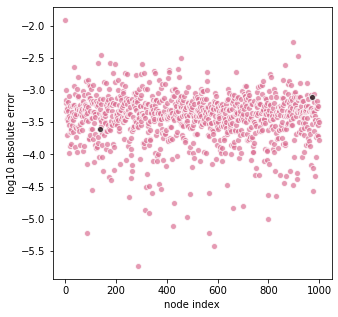

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(np.arange(len(s)), np.log10(np.abs(s_est-s)),
           color="palevioletred", edgecolor="white", alpha=0.7)

ax.scatter([node_x,node_y], np.log10(np.abs(s_est-s))[[node_x,node_y]],
           color="black", edgecolor="white", alpha=0.7)

# ax.scatter(s[621], s_est[621],
#            color="deepskyblue", edgecolor="white", alpha=0.7)

ax.set_xlabel("node index")
ax.set_ylabel("log10 absolute error")

plt.show()

### kth order update

In [27]:
s_k = []
N_k = []
for i in range(3):
    s_i, N_i = kth_order_update(A, s_0, P, order=i)
    s_k.append(s_i)
    N_k.append(N_i)

In [ ]:
error_k = []
tot_error_k = []
for s_i, N_i in zip(s_k, N_k)